In [5]:
!pip install -qqq pip
!pip install -qqq torch
!pip install -qqq transformers
!pip install -qqq datasets
!pip install -qqq accelerate
!pip install -qqq bitsandbytes
!pip install -qqq peft
!pip install -qqq trl
!pip install -qqq colored==2.2.4
!pip install -qqq nltk
!pip install -qqq rouge

### **Setup**

In [8]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    DataCollatorForLanguageModeling
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize
from rouge import rouge

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set( style = "whitegrid", palette = "muted", font_scale = 1.2 )
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "text.color": "white",
    "axes.linewidth": 0.5,
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth":  0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update( MY_STYLE )

SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
NEW_MODEL = "Llama-3-8B-Project"

In [7]:
import os
os.environ["HUGGINGFACE_HUB_TOKEN"]

KeyError: 'HUGGINGFACE_HUB_TOKEN'

### **Quantisation and Tokenisation**

In [9]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="cuda",
    quantization_config=quantization_config,
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [4]:
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
 

In [ ]:
tokenizer.bos_token, tokenizer.bos_token_id

In [ ]:
tokenizer.eos_token, tokenizer.eos_token_id

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

In [ ]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)

128256

### **Data Preprocessing**

In [ ]:
dataset=load_dataset("PatronusAI/HaluBench")

In [ ]:
dataset["test"][:2]

{'id': ['d3fb4c3c-d21b-480a-baa0-98d6d0d17c1d',
  '8603663e-c53b-46db-a482-a867f12ff3b4'],
 'passage': ['Hoping to rebound from the road loss to the Chargers, the Rams went home for Week 9, as they fought the Kansas City Chiefs in a "Show Me State Showdown". The Chiefs struck first as RB Larry Johnson got a 1-yard TD run for the only score of the period.  In the second quarter, things got worse for the Rams as QB Damon Huard completed a 3-yard TD pass to TE Tony Gonzalez, while kicker Lawrence Tynes nailed a 42-yard field goal.  St. Louis got on the board with RB Steven Jackson getting a 2-yard TD run, yet Huard and Gonzalez hooked up with each other again on a 25-yard TD strike.  Rams kicker Jeff Wilkins made a 41-yard field goal to end the half.  In the third quarter, QB Marc Bulger completed a 2-yard TD pass to WR Kevin Curtis for the only score of the period, yet the only score of the fourth quarter came from Huard completing an 11-yard TD pass to TE Kris Wilson. With the loss, the

In [ ]:
rows = []
for i in dataset["test"]:
    if isinstance(i["answer"], list):
        correct_answers = "; ".join(i["answer"])
    else:
        correct_answers = str(i["answer"])

    rows.append(
        {
            "question": i["question"],
            "context": f"Read the passage and answer the question truthfully, the passage is: {i['passage']}",
            "correct_answers": correct_answers
        }
    )

df = pd.DataFrame(rows)


In [ ]:
df.head()

,question,context,correct_answers
0,Which team scored the longest field goal kick ...,Read the passage and answer the question truth...,"['Rams', 'second', 'Marc Bulger', 'Kevin Curtis']"
1,How many percent were not Irish?,Read the passage and answer the question truth...,87.1
2,How many yards was the second longest field go...,Read the passage and answer the question truth...,42
3,How long was the last touchdown?,Read the passage and answer the question truth...,18-yard
4,How many in percent from the census weren't Ir...,Read the passage and answer the question truth...,87.1


In [ ]:
df.isnull().value_counts()

,,,count
question,context,correct_answers,
False,False,False,14900


In [ ]:
def format_example(row: dict):
  prompt = dedent(
      f"""
      ### Instruction:
      {row["context"]}

      ### Input:
      {row["question"]}

      ### Response:
      {row["correct_answers"]}
      """
  )
  messages = (
      {
          "role": "system",
          "content": "Read the passage and answer the question truthfully",
      },
      {
          "role": "user",
          "content": prompt,
      },
      {
          "role": "assistant",
          "content": row["correct_answers"],
      }
  )
  return tokenizer.apply_chat_template(messages, tokenize=False)

In [ ]:
df["text"] = df.apply(format_example, axis=1)

In [ ]:
def count_tokens(row: dict)->int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
            )["input_ids"]
        )

In [ ]:
df["token_count"] = df.apply(count_tokens, axis=1)

In [ ]:
df.head()

,question,context,correct_answers,text,token_count
0,Which team scored the longest field goal kick ...,Read the passage and answer the question truth...,"['Rams', 'second', 'Marc Bulger', 'Kevin Curtis']",<|begin_of_text|><|start_header_id|>system<|en...,318
1,How many percent were not Irish?,Read the passage and answer the question truth...,87.1,<|begin_of_text|><|start_header_id|>system<|en...,299
2,How many yards was the second longest field go...,Read the passage and answer the question truth...,42,<|begin_of_text|><|start_header_id|>system<|en...,290
3,How long was the last touchdown?,Read the passage and answer the question truth...,18-yard,<|begin_of_text|><|start_header_id|>system<|en...,297
4,How many in percent from the census weren't Ir...,Read the passage and answer the question truth...,87.1,<|begin_of_text|><|start_header_id|>system<|en...,302


In [ ]:
print(df.text.iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the passage and answer the question truthfully<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
Read the passage and answer the question truthfully, the passage is: Hoping to rebound from the road loss to the Chargers, the Rams went home for Week 9, as they fought the Kansas City Chiefs in a "Show Me State Showdown". The Chiefs struck first as RB Larry Johnson got a 1-yard TD run for the only score of the period.  In the second quarter, things got worse for the Rams as QB Damon Huard completed a 3-yard TD pass to TE Tony Gonzalez, while kicker Lawrence Tynes nailed a 42-yard field goal.  St. Louis got on the board with RB Steven Jackson getting a 2-yard TD run, yet Huard and Gonzalez hooked up with each other again on a 25-yard TD strike.  Rams kicker Jeff Wilkins made a 41-yard field goal to end the half.  In the third quarter, QB Marc Bulger completed a 2-yard TD pass to WR Kevin Curtis for the only 

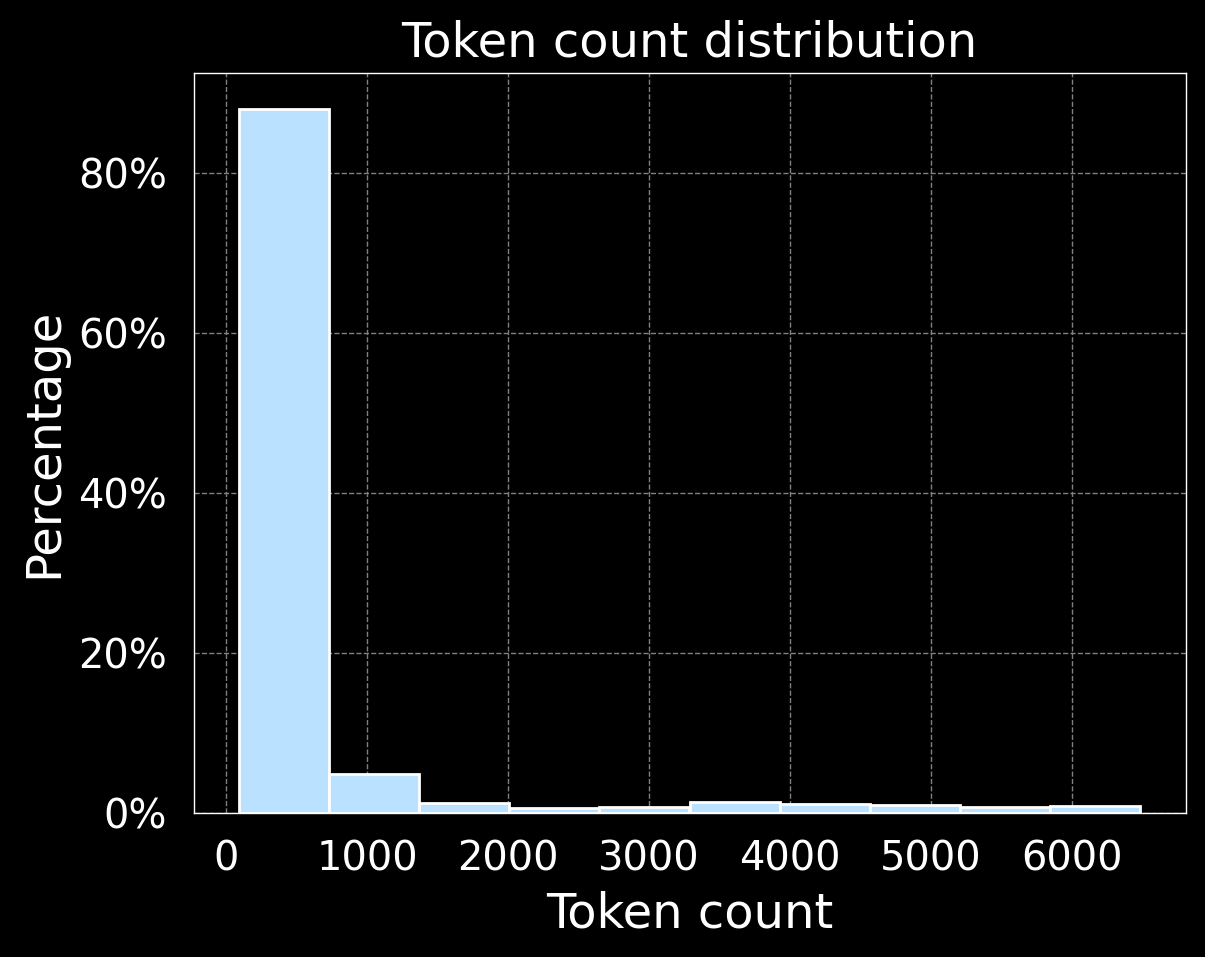

In [ ]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Token count")
plt.ylabel("Percentage")
plt.title("Token count distribution")
plt.show()

In [ ]:
upper_bound = 200
lower_bound = 10

In [ ]:
len(df[(df.token_count < upper_bound) & (df.token_count > lower_bound)]), len(df), len(df[(df.token_count < upper_bound)  & (df.token_count > lower_bound)]) / len(df)

(7650, 14900, 0.5134228187919463)

In [ ]:
total_num = 3000

In [ ]:
df = df[(df.token_count < upper_bound) & (df.token_count > lower_bound)]
df = df.sample(total_num)
df.shape

(3000, 5)

In [ ]:
train, temp = train_test_split(df, test_size=0.2, random_state=SEED)
val, test = train_test_split(temp, test_size=0.2, random_state=SEED)

In [ ]:
len(train) / len(df), len(val) / len(df), len(test) / len(df)

(0.8, 0.16, 0.04)

In [ ]:
len(train), len(val), len(test)

(2400, 480, 120)

In [ ]:
train_num = 1500
val_num = 450
test_num = 100

In [ ]:
train.sample(n=train_num).to_json("train.json", orient="records", lines=True)
val.sample(n=val_num).to_json("val.json", orient="records", lines=True)
test.sample(n=test_num).to_json("test.json", orient="records", lines=True)

In [ ]:
dataset = load_dataset(
    "json",
    data_files={
        "train": "train.json",
        "validation": "val.json",
        "test": "test.json"
        }
    )

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

In [ ]:
print(dataset["test"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the passage and answer the question truthfully<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
Read the passage and answer the question truthfully, the passage is: Ocean Beach is a village in the southern part of the Town of Islip, on Fire Island, within Suffolk County, New York, United States.Islip ( ) is one of ten towns in Suffolk County, New York (USA).

### Input:
Ocean Beach is a villiage on Fire Island which is located in one of ten towns in Suffold County New York; Where is it located?

### Response:
Fire Island is located in Islipsville.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Fire Island is located in Islipsville.<|eot_id|>


### **Test Base Model**

In [ ]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens = 128,
    return_full_text = False,
)

In [ ]:
def create_test_prompt(data_row):
  prompt = dedent(
      f"""
      ### Instruction:
      {data_row["context"]}

      ### Input:
      {data_row["question"]}

      ### Response:
      """
  )
  messages = (
      {
          "role": "system",
          "content": "Read the passage and answer the question truthfully",
      },
      {
          "role": "user",
          "content": prompt,
      },
  )
  return tokenizer.apply_chat_template(
      messages,
      add_generation_prompt=True,
      tokenize=False
  )

In [ ]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the passage and answer the question truthfully<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
Read the passage and answer the question truthfully, the passage is: Ocean Beach is a village in the southern part of the Town of Islip, on Fire Island, within Suffolk County, New York, United States.Islip ( ) is one of ten towns in Suffolk County, New York (USA).

### Input:
Ocean Beach is a villiage on Fire Island which is located in one of ten towns in Suffold County New York; Where is it located?

### Response:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
%%time
output = pipe(prompt)
response = f"""
answer: {row["correct_answers"]}
prediction: {output[0]["generated_text"]}
"""
print(response)


answer: Fire Island is located in Islipsville.
prediction: According to the passage, Ocean Beach is located in the southern part of the Town of Islip, which is one of the ten towns in Suffolk County, New York.

CPU times: user 4.24 s, sys: 213 ms, total: 4.45 s
Wall time: 8.51 s


In [ ]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the passage and answer the question truthfully<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
Read the passage and answer the question truthfully, the passage is: Casa Valentina is a play written by Harvey Fierstein which premiered on Broadway in April 2014 and opened in London in September 2015. He was inducted into the American Theater Hall of Fame in 2007.

### Input:
Harvey Fierstein wrote the play Casa Valentina. He has also wrote and stared in other plays and musicals. In what year was he inducted into the American Theater Hall of Fame?

### Response:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
%%time
output = pipe(prompt)
response = f"""
answer: {row["correct_answers"]}
prediction: {output[0]["generated_text"]}
"""
print(response)


answer: 2007
prediction: According to the passage, Harvey Fierstein was inducted into the American Theater Hall of Fame in 2007.

CPU times: user 3.17 s, sys: 135 ms, total: 3.31 s
Wall time: 5.14 s


In [ ]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Read the passage and answer the question truthfully<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:
Read the passage and answer the question truthfully, the passage is: Salvatore "Big Pussy" Bonpensiero, played by Vincent Pastore, is a fictional character on the HBO TV series "The Sopranos".The Sopranos is an American crime drama television series created by David Chase.

### Input:
Who created the crime drama television series which features a character named Salvatore "Big Pussy" Bonpensiero?

### Response:<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [ ]:
%%time
output = pipe(prompt)
response = f"""
answer: {row["correct_answers"]}
prediction: {output[0]["generated_text"]}
"""
print(response)


answer: David Chase
prediction: According to the passage, the crime drama television series "The Sopranos", which features a character named Salvatore "Big Pussy" Bonpensiero, was created by David Chase.

CPU times: user 4.06 s, sys: 255 ms, total: 4.32 s
Wall time: 4.43 s


In [ ]:
def calculate_accuracy(prediction, reference):
    pred_words = set(word_tokenize(prediction))
    ref_words = set(word_tokenize(reference))

    common_words = pred_words.intersection(ref_words)

    accuracy_pred = len(common_words) / len(pred_words) if pred_words else 0
    accuracy_ref = len(common_words) / len(ref_words) if ref_words else 0

    return accuracy_pred, accuracy_ref

In [ ]:
from rouge import Rouge
import nltk
rows = []
rouge = Rouge()
nltk.download('punkt')
nltk.download('wordnet')

for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    output = pipe(prompt)
    prediction = output[0]["generated_text"]
    reference = row["correct_answers"]

    meteor = meteor_score([word_tokenize(reference)], word_tokenize(prediction), alpha=0.9, beta=3, gamma=0.5)

    bleu = sentence_bleu([word_tokenize(reference)], word_tokenize(prediction))

    rouge_scores = rouge.get_scores(prediction, reference, avg=True)

    accuracy_pred, accuracy_ref = calculate_accuracy(prediction, reference)

    rows.append(
        {
            "question": row["question"],
            "context": row["context"],
            "answer": reference,
            "prediction": prediction,
            "meteor_score": meteor,
            "bleu_score": bleu,
            "rouge_1": rouge_scores['rouge-1']['f'],
            "rouge_2": rouge_scores['rouge-2']['f'],
            "rouge_l": rouge_scores['rouge-l']['f'],
            "Accuracy_pred": accuracy_pred,
            "Accuracy_ref": accuracy_ref
        }
    )

predictions_df = pd.DataFrame(rows)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  1%|          | 1/100 [00:06<11:16,  6.84s/it]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/pyt

In [ ]:
predictions_df.to_csv('base_eval.csv', index=False)